# CMSE 202 Project Notebook

In [49]:
import ecosystem
import random
import numpy as np
import matplotlib.pyplot as plt

### 1) Finding the best parameters for Cod Births and Cod Deaths

In [4]:
np.sum(True)

1

In [76]:
# No Invasive Species
cod_itr = []
for i in range(500):
    ecosystem.reset_pops()
    cbr = random.uniform(.5, 2.25)
    cdr = random.uniform(0.01, 0.3)
    ecosystem.run(cod_birth_rate=cbr, cod_death_rate=cdr)
    cod_itr.append([cbr, cdr, sum(ecosystem.eco_data['cod_pop']), 0, np.sum(np.sum(np.array(ecosystem.eco_data['cod_pop']) < 3) > 0)])

    ecosystem.reset_pops()
    ecosystem.run(invasive=True,cod_birth_rate=cbr, cod_death_rate=cdr)
    cod_itr.append([cbr, cdr, sum(ecosystem.eco_data['cod_pop']), 1, np.sum(np.sum(np.array(ecosystem.eco_data['cod_pop']) < 3) > 0)])

In [77]:
cod_itr = np.array(cod_itr)

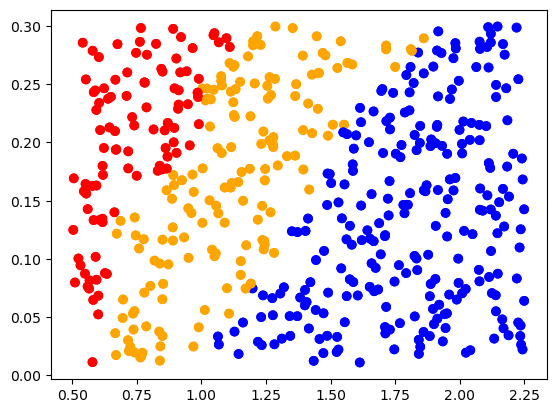

In [78]:
cmap = []
for i in range(len(cod_itr[:,4])):
    if cod_itr[i,4] == 1 and cod_itr[i,3] == 0:
        cmap.append('red')
    elif cod_itr[i,4] == 1 and cod_itr[i,3] == 1:
        if cod_itr[i-1,4] == 1:
            cmap.append('red')
        else:
            cmap.append('orange')
    elif i % 2 == 0 and cod_itr[i+1,4] == 1:
        cmap.append('orange')
    else:
        cmap.append('blue')
plt.scatter(cod_itr[:,0], cod_itr[:,1], color=cmap)

#### No Invasive Species

In [172]:
# No Invasive Species
cod_itr = []
for i in range(250):
    ecosystem.reset_pops()
    cbr = random.uniform(.5, 2.25)
    cdr = random.uniform(0.01, 0.3)
    ecosystem.run(cod_birth_rate=cbr, cod_death_rate=cdr)
    cod_itr.append([cbr, cdr, sum(ecosystem.eco_data['cod_pop']), 0, np.sum(np.sum(np.array(ecosystem.eco_data['cod_pop']) < 3) > 0)])

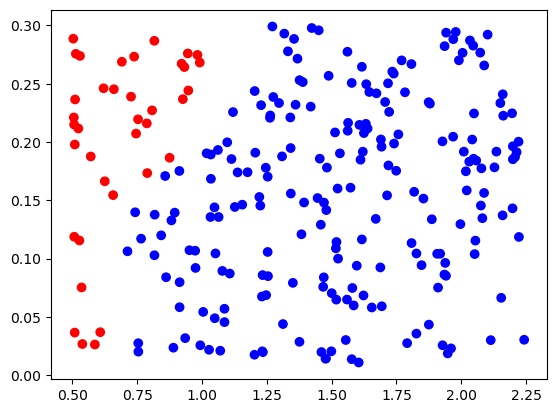

In [173]:
cod_itr = np.array(cod_itr)

cmap = np.where(cod_itr[:,4] == 1, 'red', 'blue')

plt.scatter(cod_itr[:,0], cod_itr[:,1], color=cmap)

#### Running an SVM

In [133]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_lfw_people
import time

In [174]:
feature_vectors = cod_itr[:,(0,1)]
class_labels = cod_itr[:,4] # 1 == Population did crash (hit zero)

In [175]:
train_vectors, test_vectors, train_labels, test_labels = train_test_split(feature_vectors, class_labels, test_size=.25, train_size=.75)

**SVM Classification Model**

In [176]:
start = time.time()
# a dictionary of hyperparameters: key is the name of the parameter, value is a list of values to test
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
              'kernel': ['linear']}
# make a classifier by searching over a classifier and the parameter grid
clf = GridSearchCV(SVC(class_weight='balanced'), param_grid)

# we have a "good" classifier (according to GridSearchCV), how's it look
clf = clf.fit(feature_vectors, class_labels)
print("Best estimator found by grid search:")
print(clf.best_estimator_)
print("Best parameters found by grid search:")
print(clf.best_params_)
end = time.time()
print("Runtime",end - start)

Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0001, kernel='linear')
Best parameters found by grid search:
{'C': 1000.0, 'gamma': 0.0001, 'kernel': 'linear'}
Runtime 0.2802846431732178


In [177]:
pred_class = clf.predict(test_vectors)

In [178]:
pred_class == test_labels

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [181]:
w1, w2 = clf.best_estimator_.coef_[0]
b = clf.best_estimator_.intercept_[0]

(0.0, 0.32)

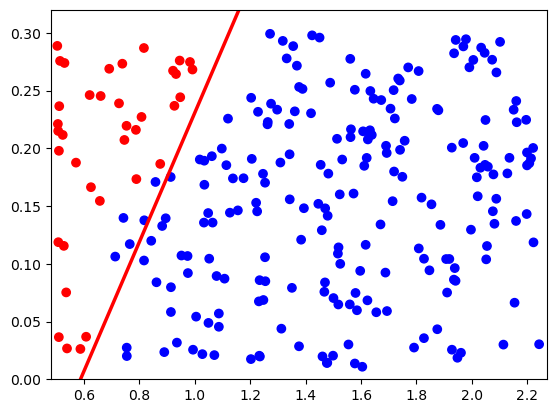

In [182]:
def point(x, w1, w2, b):
    return -w1 / w2 * x - b / w2

line = [point(0, w1, w2, b), point(2.25, w1, w2, b)]
plt.plot([0, 2.25], line, color='red', lw=2.5)
plt.scatter(cod_itr[:,0], cod_itr[:,1], color=cmap)
plt.xlim(.48, 2.27)
plt.ylim(0, .32)

#### With Invasive Species

In [161]:
# Invasive Species
cod_itr = []
for i in range(250):
    ecosystem.reset_pops()
    cbr = random.uniform(.5, 2.25)
    cdr = random.uniform(0.01, 0.3)
    ecosystem.run(invasive=True, cod_birth_rate=cbr, cod_death_rate=cdr)
    cod_itr.append([cbr, cdr, sum(ecosystem.eco_data['cod_pop']), 1, np.sum(np.sum(np.array(ecosystem.eco_data['cod_pop']) < 3) > 0)])

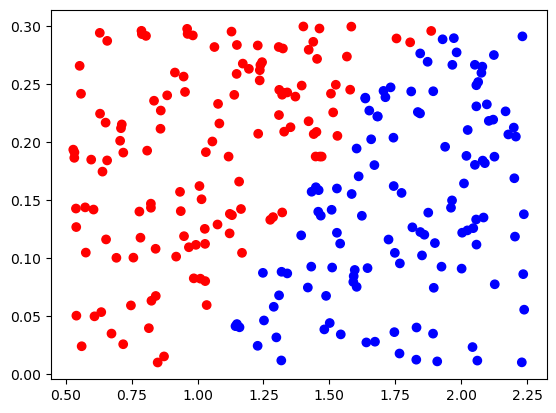

In [162]:
cod_itr = np.array(cod_itr)

cmap = np.where(cod_itr[:,4] == 1, 'red', 'blue')

plt.scatter(cod_itr[:,0], cod_itr[:,1], color=cmap)

**SVM**

In [163]:
feature_vectors = cod_itr[:,(0,1)]
class_labels = cod_itr[:,4] # 1 == Population did crash (hit zero)

In [164]:
train_vectors, test_vectors, train_labels, test_labels = train_test_split(feature_vectors, class_labels, test_size=.25, train_size=.75)

In [165]:
start = time.time()
# a dictionary of hyperparameters: key is the name of the parameter, value is a list of values to test
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
              'kernel': ['linear']}
# make a classifier by searching over a classifier and the parameter grid
clf = GridSearchCV(SVC(class_weight='balanced'), param_grid)

# we have a "good" classifier (according to GridSearchCV), how's it look
clf = clf.fit(feature_vectors, class_labels)
print("Best estimator found by grid search:")
print(clf.best_estimator_)
print("Best parameters found by grid search:")
print(clf.best_params_)
end = time.time()
print("Runtime",end - start)

Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0001, kernel='linear')
Best parameters found by grid search:
{'C': 1000.0, 'gamma': 0.0001, 'kernel': 'linear'}
Runtime 0.4328460693359375


In [166]:
pred_class = clf.predict(test_vectors)
pred_class == test_labels

array([ True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

(0.0, 0.32)

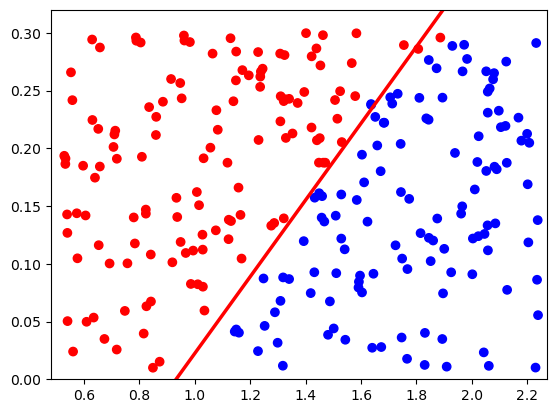

In [168]:
w1, w2 = clf.best_estimator_.coef_[0]
b = clf.best_estimator_.intercept_[0]

def point(x, w1, w2, b):
    return -w1 / w2 * x - b / w2

inv_line = [point(0, w1, w2, b), point(2.25, w1, w2, b)]
plt.plot([0, 2.25], inv_line, color='red', lw=2.5)
plt.scatter(cod_itr[:,0], cod_itr[:,1], color=cmap)
plt.xlim(.48, 2.27)
plt.ylim(0, .32)

#### Putting Them Together

In [185]:
# Both
cod_itr = []
for i in range(500):
    ecosystem.reset_pops()
    cbr = random.uniform(.5, 2.25)
    cdr = random.uniform(0.01, 0.3)
    ecosystem.run(cod_birth_rate=cbr, cod_death_rate=cdr)
    cod_itr.append([cbr, cdr, sum(ecosystem.eco_data['cod_pop']), 0, np.sum(np.sum(np.array(ecosystem.eco_data['cod_pop']) < 3) > 0)])

    ecosystem.reset_pops()
    ecosystem.run(invasive=True,cod_birth_rate=cbr, cod_death_rate=cdr)
    cod_itr.append([cbr, cdr, sum(ecosystem.eco_data['cod_pop']), 1, np.sum(np.sum(np.array(ecosystem.eco_data['cod_pop']) < 3) > 0)])

In [186]:
cod_itr = np.array(cod_itr)

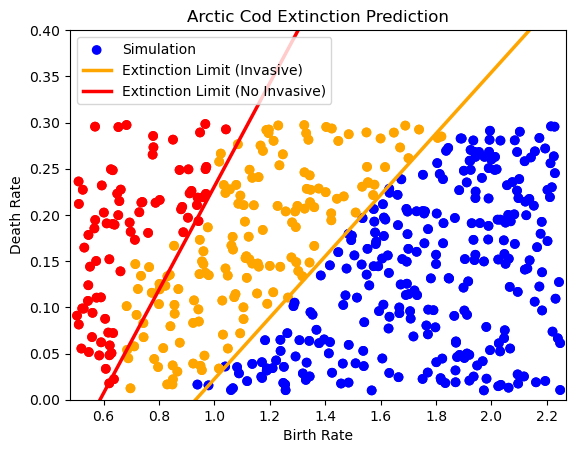

In [223]:
cmap = []
for i in range(len(cod_itr[:,4])):
    if cod_itr[i,4] == 1 and cod_itr[i,3] == 0:
        cmap.append('red')
    elif cod_itr[i,4] == 1 and cod_itr[i,3] == 1:
        if cod_itr[i-1,4] == 1:
            cmap.append('red')
        else:
            cmap.append('orange')
    elif i % 2 == 0 and cod_itr[i+1,4] == 1:
        cmap.append('orange')
    else:
        cmap.append('blue')
plt.scatter(cod_itr[:,0], cod_itr[:,1], color=cmap)
plt.plot([0, 2.25], inv_line, color='orange', lw=2.5)
plt.plot([0, 2.25], line, color='red', lw=2.5)
plt.xlim(.48, 2.27)
plt.ylim(0, .4)
plt.title("Arctic Cod Extinction Prediction")
plt.xlabel("Birth Rate")
plt.ylabel("Death Rate")
plt.legend(['Simulation', 'Extinction Limit (Invasive)', 'Extinction Limit (No Invasive)'], loc="upper left")